In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.sparse import csr_matrix
from scipy.spatial import distance
import os
import warnings; warnings.simplefilter('ignore')
import anndata
import scrublet as scr

import seaborn as sns
sns.set_style('white')

np.random.seed(0)
sc.settings.verbosity = 3 
sc.set_figure_params(scanpy=True, dpi=80)

In [2]:
sc.logging.print_versions()

scanpy==1.4.5 anndata==0.7.5 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


### 5A

In [4]:
adata = sc.read('veatch_myeloid_all20.h5ad')

In [6]:
sc.set_figure_params(scanpy=True, dpi=80)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


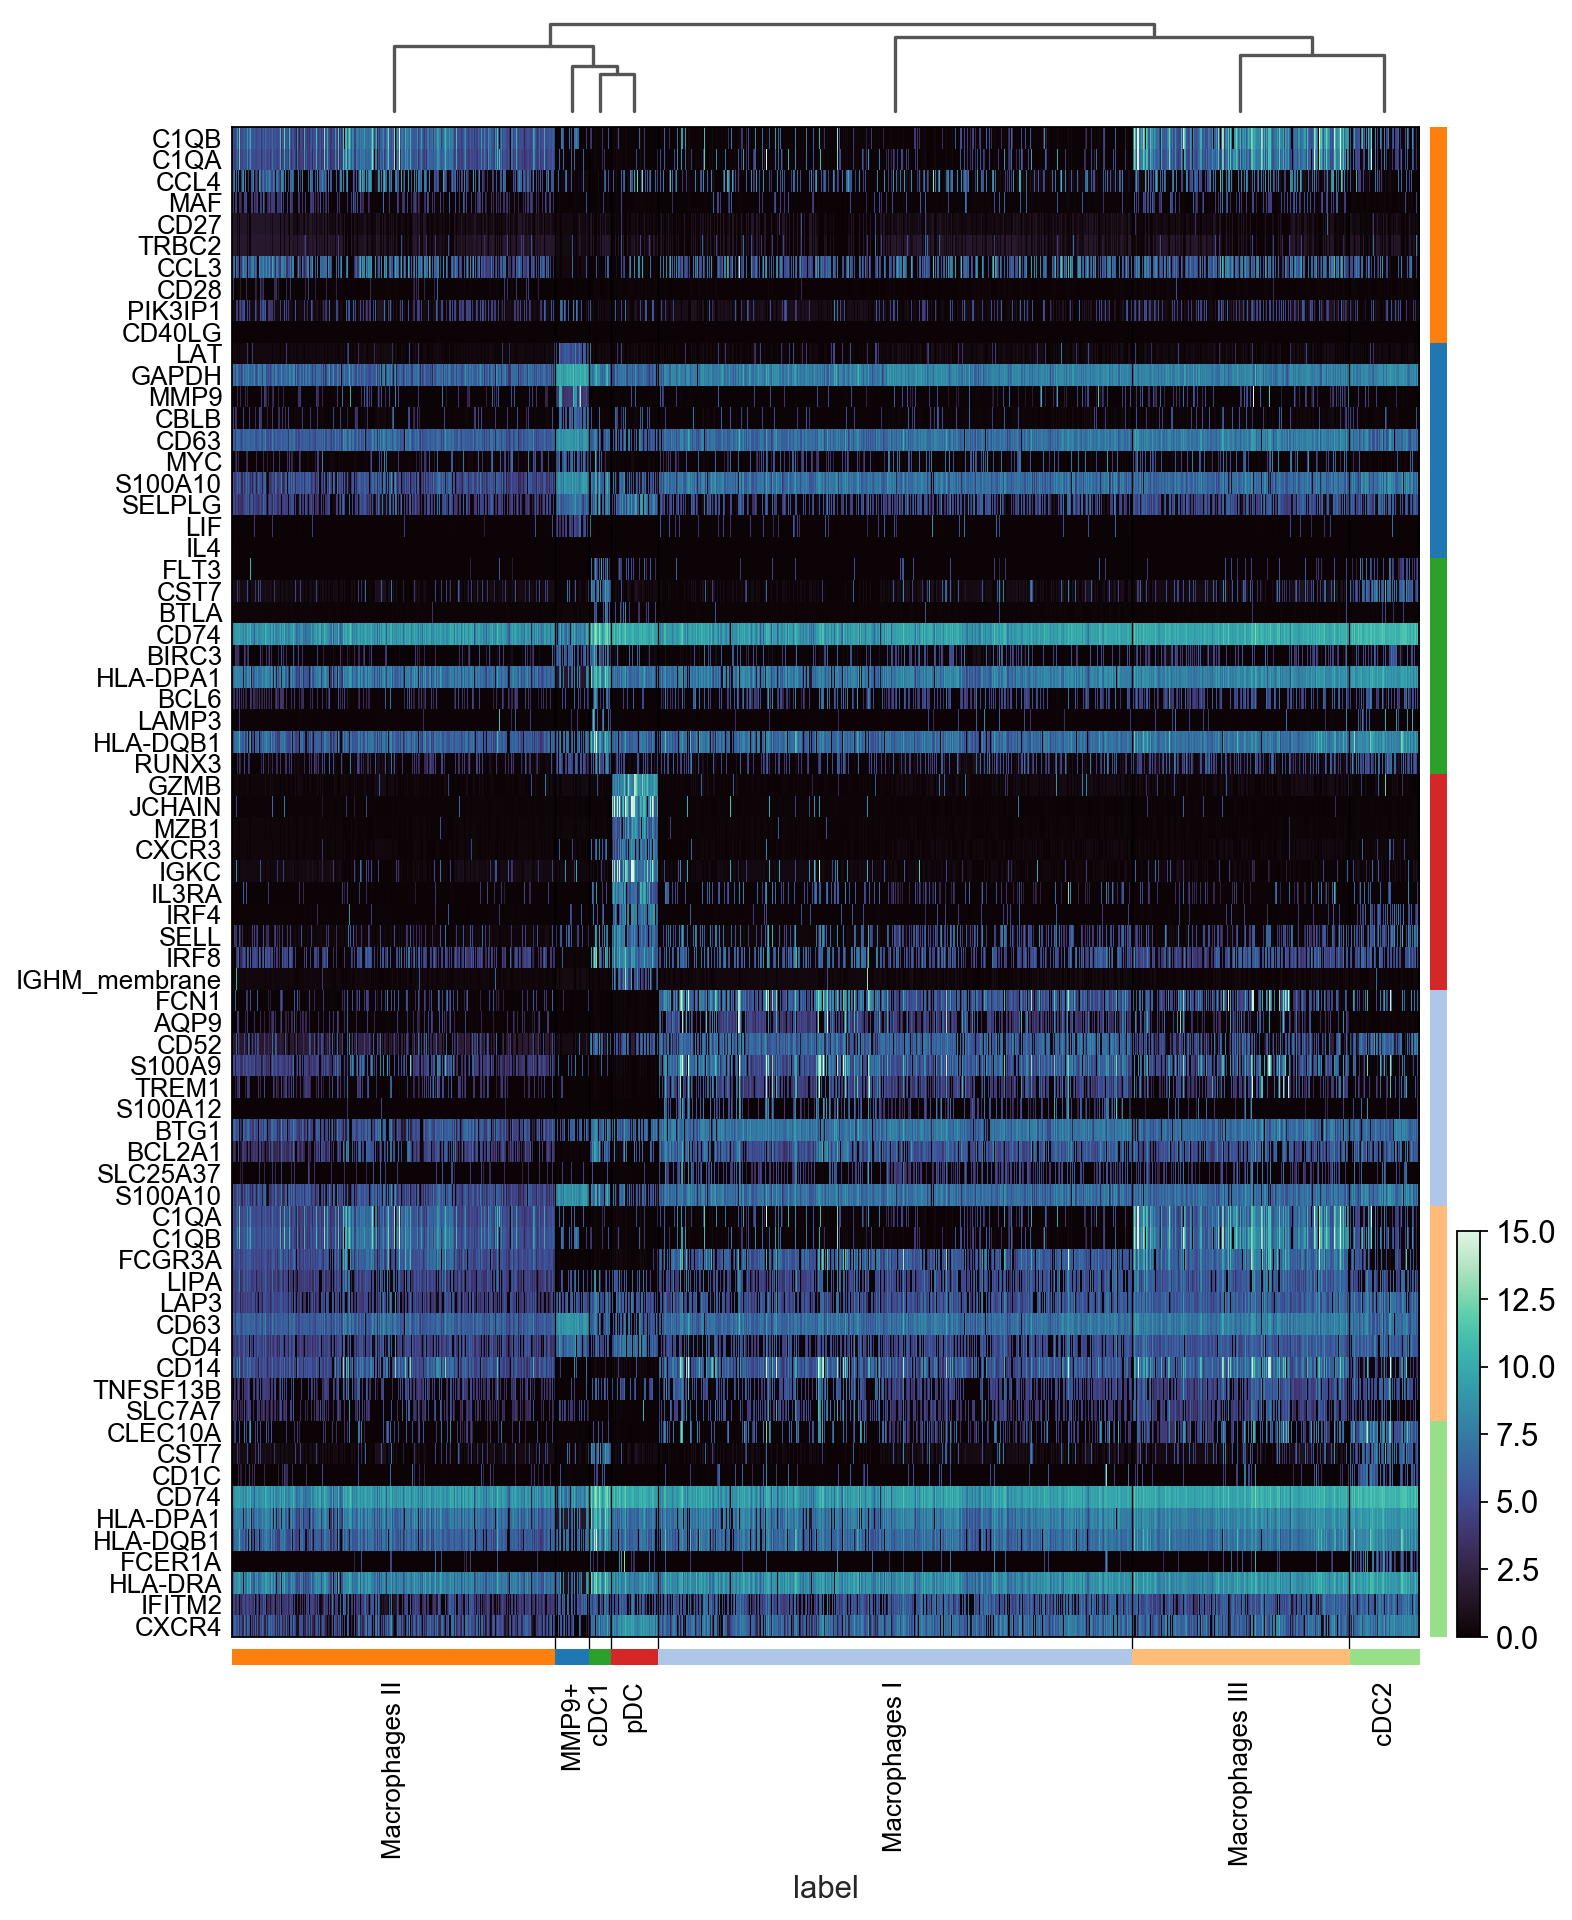

In [7]:
sc.tl.rank_genes_groups(adata, groupby='label')
sc.pl.rank_genes_groups_heatmap(adata, groupby='label', n_genes=10,cmap='mako',
                                swap_axes=True,show_gene_labels=True,vmin=0,vmax=15)

### 5B

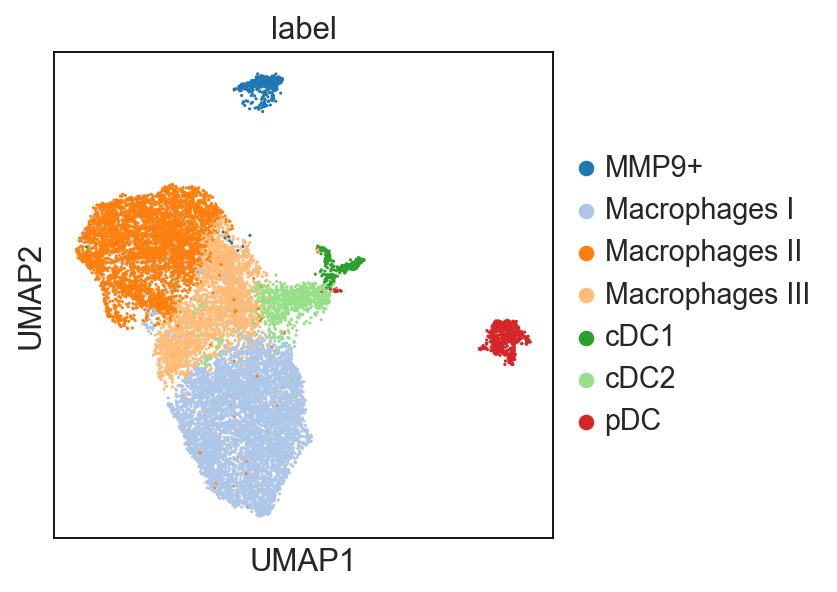

In [8]:
sc.pl.umap(adata, color='label',
           palette=sns.color_palette("tab20", 8),
           alpha = 1)

### 5G

In [9]:
from scattermap import scattermap

In [26]:
pvals = pd.read_csv('pvalues.txt',sep='\t')
means = pd.read_csv('significant_means.txt',sep='\t')

In [27]:
cols = ['CD4 T CXCL13+ TCF7+|B',
       'CD4 T CXCL13+ TCF7+|CD8 T', 'CD4 T CXCL13+ TCF7+|myeloid',
       'CD4 T CXCL13+ TCF7-|B', 'CD4 T CXCL13+ TCF7-|CD8 T',
       'CD4 T CXCL13+ TCF7-|myeloid', 'CD4 T CXCL13-|B', 'CD4 T CXCL13-|CD8 T',
       'CD4 T CXCL13-|myeloid', 'CD4 T FOXP3+|B', 'CD4 T FOXP3+|CD8 T',
       'CD4 T FOXP3+|myeloid']

In [28]:
pvals.index = pvals['interacting_pair']
means.index = means['interacting_pair']

In [29]:
p = pvals[cols]
m = means[cols]

In [30]:
logp = -np.log(p.values+ 0.00000000001)
logp += 0.1

In [31]:
size_exponent = 1
largest_dot = np.max(logp)
smallest_dot = np.min(logp)
dot_min = 0
dot_max = 1

(0.13077134842971808, 5.239413843699276)

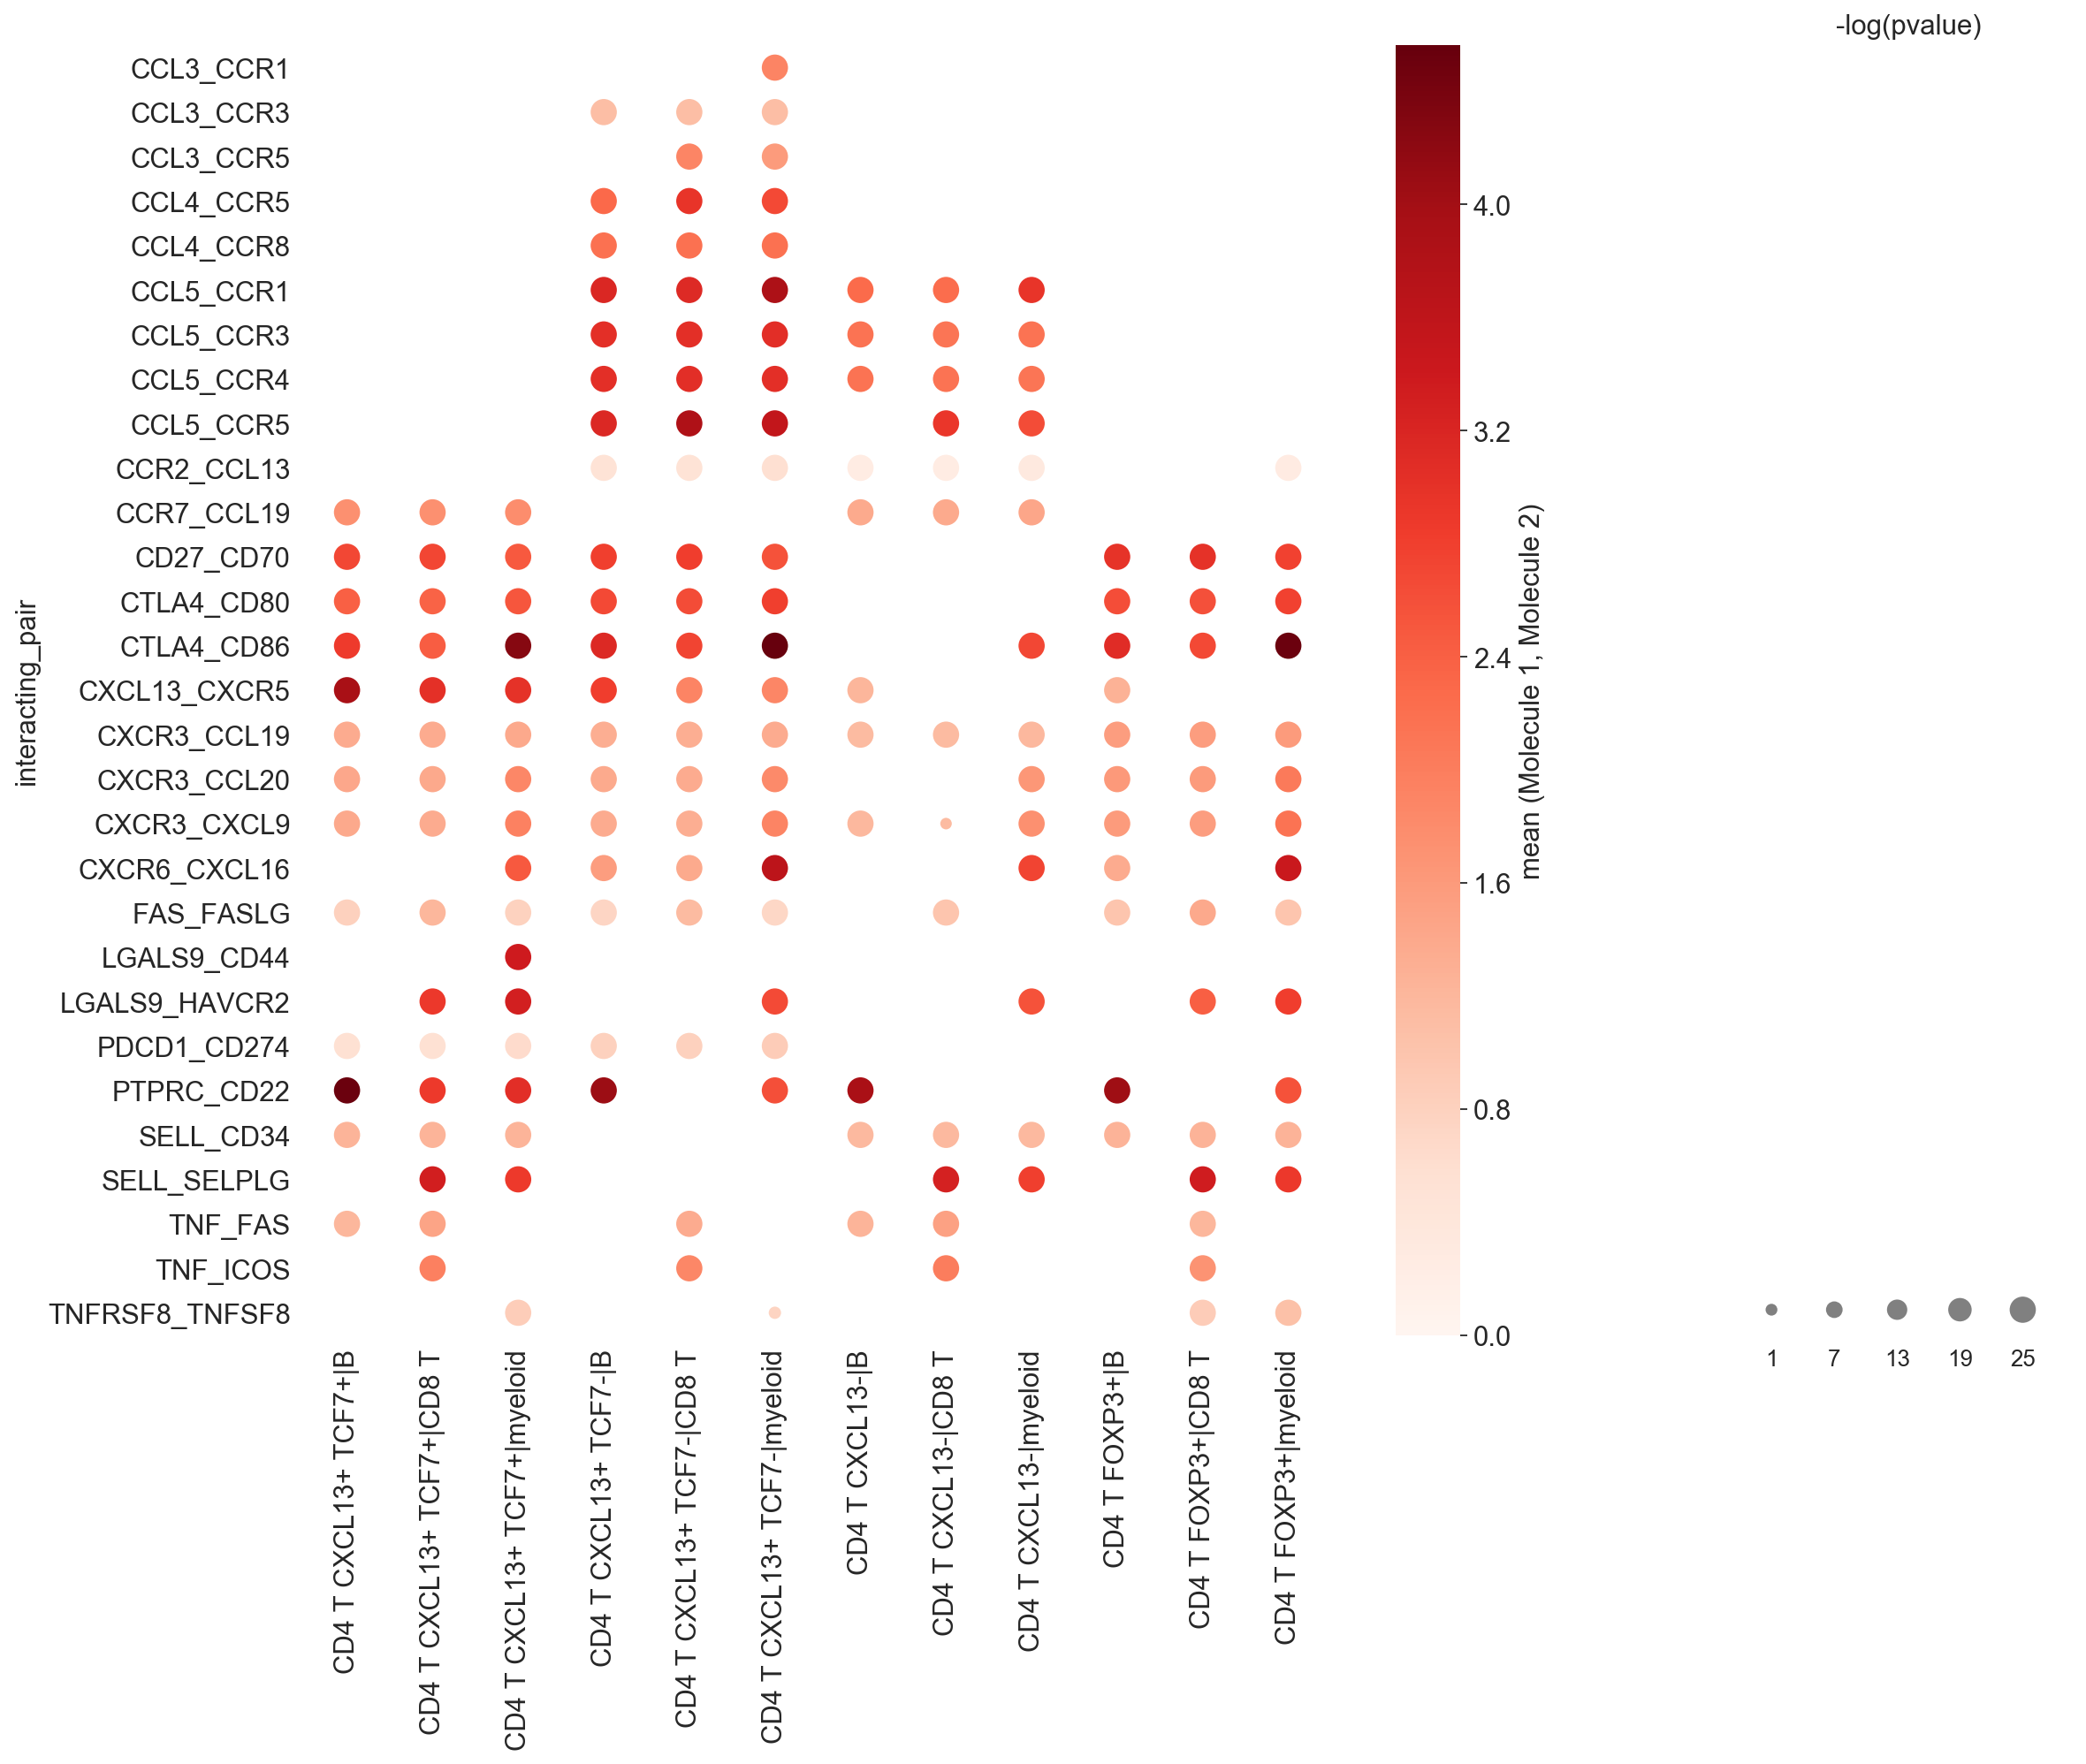

In [32]:
sns.set_style('white')

fig, ax = plt.subplots(figsize=(16,12),nrows=1,ncols=2, gridspec_kw={'width_ratios': [4, 1]})

scattermap(m,cmap='Reds',ax=ax[0],marker_size=logp*7,vmin=0,cbar_kws={"label": "mean (Molecule 1, Molecule 2)"})

diff = dot_max - dot_min
if 0.3 < diff <= 0.6:
    step = 0.1
elif diff <= 0.3:
    step = 0.05
else:
    step = 0.2
# a descending range that is afterwards inverted is used
# to guarantee that dot_max is in the legend.
size_range = np.arange(dot_max, dot_min, step * -1)[::-1]
s_range = np.arange(largest_dot, smallest_dot, 6 * -1)[::-1]
if dot_min != 0 or dot_max != 1:
    dot_range = dot_max - dot_min
    size_values = (size_range - dot_min) / dot_range
else:
    size_values = size_range

size = size_values ** size_exponent
size = size * (largest_dot - smallest_dot) + smallest_dot

# plot size bar
ax[1].scatter(
    np.arange(len(size)) + 0.5,
    np.repeat(0, len(size)),
    s=size*7,
    color='gray',
    edgecolor='black',
    linewidth=0,
    zorder=100,
)
ax[1].set_xticks(np.arange(len(size)) + 0.5)
labels = [
    "{}".format(np.round((x), decimals=0).astype(int)) for x in s_range
]
ax[1].set_xticklabels(labels, fontsize='small')

# remove y ticks and labels
ax[1].tick_params(
    axis='y', left=False, labelleft=False, labelright=False
)

# remove surrounding lines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].grid(False)

ymax = ax[1].get_ylim()[1]
#ax[1].set_ylim(-1.05 - largest_dot * 0.003, 4)
ax[1].set_ylim(-1,50)
ax[1].set_title('-log(pvalue)', y=ymax, size='medium')

xmin, xmax = ax[1].get_xlim()
ax[1].set_xlim(xmin - 0.15, xmax + 0.5)